### Implementing XGBoost in Python


#### Steps and Notes for XGBoost
+ **Step 1**: Start with initial prediction. The default is 0.5 for classification and regression.
+ **Step 2**: Build a tree just like we do for XGBoost for regression. The root node starts with all the residuals in it.
+ **Step 3**: Calculate the similarity score of the leaf node. The similarity score is (sum of residuals)^2 / Sum[(Prev Prob.i * (1- Prev Prob.i)] + regularization term)
+ **Step 4**: Cluster similar residuals by splitting the tree. For each potential split, send the residuals down the tree into the potential left and right leaf nodes. Then, calculate the similarity score for the left and right leaves by plugging in the given leaf to the formula. Higher similarity means similar residuals.
+ **Step 5**: Calculate the gain just like we do for regression XGBoost. Gain = Left similarity + Right similarity - Root similarity. The highest gain is the best split. Keep building the tree as long as cover is not less than the predetermined threshold. (min_child_weight). The formula for cover is Sum[Prev Prob.i * (1 - Prev Prob.i)]
+ **Step 6**: Prune if needed. If Gain-Gamma is positive do not prune.
+ **Step 7**: Determine the output of the leaves. Output = Sum(residuals in the leaf) / Sum[Prev Prob.i * (1 - Prev Prob.i)] + regularization term.
+ Step 8**: Convert initial probability to log odds. Then, add this log odds to the output of the current tree * learning rate. The default learning rate is 0.3.
+ **Step 9**: Convert back to probability using e^log odds / (1 + e^log odds).
+ XGBoost cannot handle object datatypes. Convert to boolean or OneHotEncode them.
+ When using dataviz to draw the tree we cannot have whitespaces so convert them to underscores.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# configure pandas to see all columns
pd.set_option('display.max_columns', None)

In [3]:
# import data
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Now we can get a look at our columns. For each column we will print the column name followed by the length of the unique values and the unique values themselves. This tells us what variables are boolean.

In [7]:
for col in df.columns:
    print(col, len(df[col].unique()), df[col].unique())

customerID 7043 ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender 2 ['Female' 'Male']
SeniorCitizen 2 [0 1]
Partner 2 ['Yes' 'No']
Dependents 2 ['No' 'Yes']
tenure 73 [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService 2 ['No' 'Yes']
MultipleLines 3 ['No phone service' 'No' 'Yes']
InternetService 3 ['DSL' 'Fiber optic' 'No']
OnlineSecurity 3 ['No' 'Yes' 'No internet service']
OnlineBackup 3 ['Yes' 'No' 'No internet service']
DeviceProtection 3 ['No' 'Yes' 'No internet service']
TechSupport 3 ['No' 'Yes' 'No internet service']
StreamingTV 3 ['No' 'Yes' 'No internet service']
StreamingMovies 3 ['No' 'Yes' 'No internet service']
Contract 3 ['Month-to-month' 'One year' 'Two year']
PaperlessBilling 2 ['Yes' 'No']
PaymentMethod 4 ['Electronic check' 'Mailed check' 'Ban

In [8]:
df.drop('customerID', axis=1, inplace=True)

In [9]:
# total charges should be numeric but has an empty string so we cant do it easily.
df.loc[df['TotalCharges'] == ' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [10]:
# replace the empty space with a 0
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)

In [11]:
# make sure these are the same 11 we had previously
df.loc[df['TotalCharges'] == 0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [12]:
# now convert the column to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [13]:
# make sure there is no whitespaces in any columns so that we can draw the tree
df.replace(' ', '_', regex=True, inplace=True)

##### Split the Data

As we will see shortly, we are going to use **early stopping**. Early stopping is a way to stop training as soon as the validation error reaches a minimum. As we train a model, the prediction error will go down on both the training and validation sets however, after a while, the validation error will start to go back up which means we have started to overfit the data. The metric we will be using is **aucpr**. If the validation aucpr score does not improve for 10 rounds we will stop learning. This will also make the model train faster.

The breakdown is as follows:
+ Step One: Split the data so that we have 20 percent for X_test and y_test. The other 80% will be X_train_val and y_train val.
+ Step Two: Create the training and validation set by splitting X_train_val and y_train val. Keep 20 percent for validation set.

In [14]:
# replace the Churn target variable with 1 for Churn and 0 for no Churn
df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})

C:\Users\ryans\AppData\Local\Temp\ipykernel_30952\1736284044.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'Yes': 1, 'No': 0})


In [15]:
# create X and y splits
X = df.drop('Churn', axis = 1).copy()
y = df['Churn'].copy()

In [16]:
# encode the categorical data using pd.get_dummies()
X_encoded = pd.get_dummies(X)

In [17]:
X_encoded

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,True,False,False,True,True,False,True,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,False,True,True,False,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,False,True,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,True,False,True,False,True,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,84.80,1990.50,False,True,False,True,False,True,False,True,False,False,True,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True
7039,0,72,103.20,7362.90,True,False,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,False,True,False,True,False,False
7040,0,11,29.60,346.45,True,False,False,True,False,True,True,False,False,True,False,True,False,False,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,False
7041,1,4,74.40,306.60,False,True,False,True,True,False,False,True,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,True


##### Check the Balance of the Data

Since the data is imbalanced we will use the scoring metric **aucpr**. This helps with imbalanced datasets because accuracy scores can be misleading since the minority class is more rare. It is the area under the precision recall curve. The closer this value is to 1 the better. 

Precision:
+ Ratio of correctly predicted positive class (churns) to the total predicted positive class (churns)

Recall/Sensitivity:
+ Ratio of correctly predicted positive observations (churns) to all actual positive (churns)

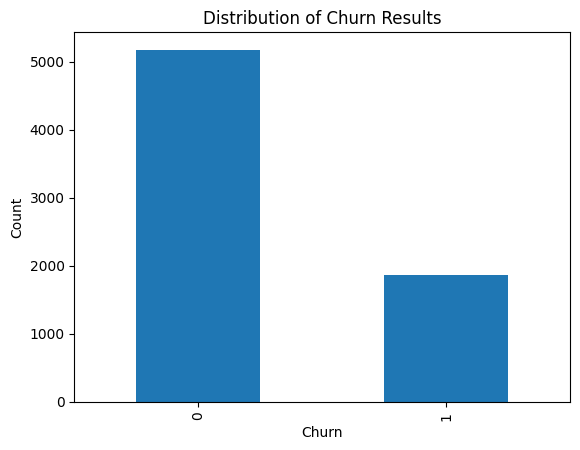

In [18]:
import matplotlib.pyplot as plt

# create counts for each
churn_counts = df['Churn'].value_counts()

# create plot
fig, ax = plt.subplots()
churn_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_title('Distribution of Churn Results')
plt.show()


In [19]:
# how imbalanced is it
counts = df['Churn'].value_counts(normalize=True)
counts

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [21]:
# stratify split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)


In [22]:
# check distribution
y_train_val.value_counts(normalize=True)

Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

In [23]:
# verify stratification
y_test.value_counts(normalize=True)

Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

In [24]:
# further split X_train_val and y_train_val to make validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

In [25]:
# verify stratification
y_train.value_counts(normalize=True)

Churn
0    0.734635
1    0.265365
Name: proportion, dtype: float64

In [26]:
# verify stratification
y_val.value_counts(normalize=True)

Churn
0    0.734694
1    0.265306
Name: proportion, dtype: float64

In [33]:
# build the first model 
clf_xgb = XGBClassifier(objective='binary:logistic', eval_metric = 'aucpr', early_stopping_rounds = 10, seed=42) 
clf_xgb.fit(X_train,
            y_train,
            verbose = True,
            eval_set = [(X_val, y_val)])

[0]	validation_0-aucpr:0.61917
[1]	validation_0-aucpr:0.63717
[2]	validation_0-aucpr:0.63397
[3]	validation_0-aucpr:0.63668
[4]	validation_0-aucpr:0.63957
[5]	validation_0-aucpr:0.63184
[6]	validation_0-aucpr:0.64079
[7]	validation_0-aucpr:0.64561
[8]	validation_0-aucpr:0.64636
[9]	validation_0-aucpr:0.64478
[10]	validation_0-aucpr:0.64321
[11]	validation_0-aucpr:0.64515
[12]	validation_0-aucpr:0.64556
[13]	validation_0-aucpr:0.64463
[14]	validation_0-aucpr:0.64444
[15]	validation_0-aucpr:0.64520
[16]	validation_0-aucpr:0.64382
[17]	validation_0-aucpr:0.64384
[18]	validation_0-aucpr:0.64097


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

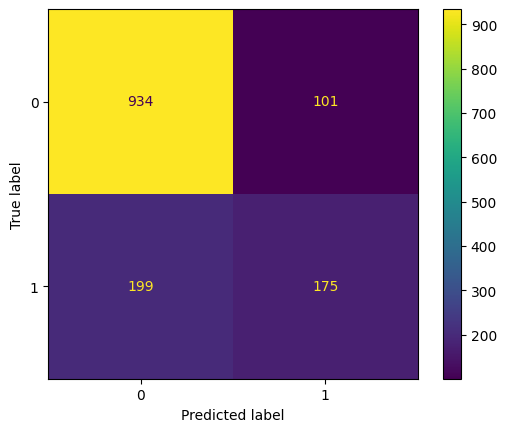

In [ ]:
# create confusion matrix plot
ConfusionMatrixDisplay.from_estimator(clf_xgb, X_test, y_test)
plt.show()

#### Scoring Metrics

In [37]:
# valuation
true_negative = 934
false_positive = 101
false_negative = 199
true_positive = 175


Accuracy is the proportion of correctly classified instances. This number may be misleading for highly imbalanced datasets.
$$Accuracy = \frac{TN + TP}{TN + FP + FN + TP}$$


In [41]:
# accuracy score
accuracy_score = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
print(f'The model has an accuracy score of: {accuracy_score:.3f}')

The model has an accuracy score of: 0.787


Precision is the proportion of positive predictions that were correct. This is asking, "out of our positive predictions, how well did we do?" Or, "When we say positive, are we doing well." This calculation tries to reduce the false positives. If there are no false positives in our predictions then we are very good at making positive predictions and our precision will be 1. 
$$Precision = \frac{TP}{TP + FP}$$

Our model successfully predicted 175 of the true churners (True Positives), but incorrectly predicted 101 to churn as well (False Positives). This means that out of 276 predicted churners (175 True Positives + 101 False Positives), 175 predictions were correct.

In [43]:
# precision
precision_score = true_positive / (true_positive + false_positive)
print(f'The model has a precision score of: {precision_score:.3f}.')

The model has a precision score of: 0.634.


Recall is the proportion of actual positive cases that were correctly predicted. It is similar to precision but instead of grading our positive predictions we are grading our performance on the actual positive cases. This equation tries to minimize the false negatives. If this were a cancer diagnosis we would car more about recall rather than precision because a false negative is more costly than a false positive. 
$$Recall = \frac{TP}{TP + FN}$$

The model correctly classified 175 true churners but incorrecly classified 199 additional churners as non-churners. This means, out of the 374 actual churners we only predicted 175 correctly.

In [52]:
recall = true_positive / (true_positive + false_negative)
print(f'The model has a recall score of: {recall:.3f}')

The model has a recall score of: 0.468


##### Precision vs. Recall 

For churn data, high precision means that when we predict churn they are very likely to churn. This can give us insights on who we should reach out to and offer more services like discounts. A high recall in this example would mean we are good at identifying customers who churn. For example, if losing a customer is very costly, we would not care as much about false positives because we cannot lose someone. It is the false negatives that we care about more because we would not reach out to someone likely to churn. In this case we would like to balance both which is where the F1-score comes in to play. The F-1 score balances the trade-off between precision and recall. If we were to have **high precision and low recall** our model would catch most of the churners (high precision) but miss some (low recall due to false negatives). If we were to have **high recall and low precision** we would catch almost all churners (high recall) but incorrectly classify many non-churners as churners (low percision due to false positives). 

$$
F1 \, \text{Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [57]:
# manual implementation
f1_score = 2 * ((precision_score * recall) / (precision_score + recall))
print(f'{f1_score:.3f}')

0.538


In [59]:
from sklearn.metrics import f1_score

y_pred = clf_xgb.predict(X_test)
f1_sklearn = f1_score(y_test, y_pred)
print(f'{f1_sklearn:.3f}')

0.538


scale_pos_weight adds a penalty to incorrectly classified minority class predictions.